### Setup environment ###

As a fist step, we install and import all necessary modules and set a deterministic random seed.

In [1]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 3.7 MB/s 


In [2]:
import os
import re
import csv
import glob
import torch
import torchvision
import numpy as np
import seaborn as sns
import pandas as pd
import rasterio as rio
import torch.nn.functional as F
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from torch import nn, optim
from sklearn.metrics import classification_report
from torch.utils import data
from typing import List
from rasterio.plot import reshape_as_image
from sklearn.metrics import confusion_matrix


# init deterministic seed
seed_value = 1234
np.random.seed(seed_value)  # set numpy seed
torch.manual_seed(seed_value)  # set pytorch seed

We create a mapping from prediction label to int and vice versa that will be used throughout the notebook.

In [3]:
classes_to_int = {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9,
}
classes_to_label = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake",
}

## Download Data ##
We download the training dataset and unzip the contents. 

In [4]:
# This can take a few minutes
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
!unzip /content/EuroSATallBands.zip

Streaming output truncated to the last 5000 lines.
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_2294.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_1854.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_1426.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_1381.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_647.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_581.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_226.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_2819.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_922.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/SeaLake/SeaLake_550.tif  
  inflating: d

## Define directory paths ##

We define the directories in which models are stored and the raw data can be found and the submission data is stored. Additionally, we also create the folder where the trained models should be stored.

In [5]:
!mkdir models
MODELS_PATH = "models"
DATA_PATH = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
SUBMISSION_DATA_PATH = "submission_dataset/testset"

## Data Loading ##

For the data loading we use a custom torch dataset which loads data into memory. We also integrate normalization (mean 0, std 1) into the data loading.

In [6]:
# Get a list of all available files for training
samples = glob.glob(os.path.join(DATA_PATH, "*", "*.tif"))
print(len(samples))

27000


Before we create our dataset, we need to use a normalization method. To create the normalizer we first compute the means and standard deviations over all bands from all samples. In this notebook we can make use of pre-computed values.

In [7]:
# Create normalizer for 13 bands with precomputed means and standard deviations across all bands
means_tuple = (1353.7269257269966, 1117.2022923538773, 1041.8847248444733, 946.5542548737702, 1199.1886644965277, 2003.0067999222367, 2374.008444688585, 2301.2204385489003, 732.1819500777633, 1820.6963775318286, 1118.2027229275175, 2599.7829373281975)
stds_tuple = (65.29657739037496, 153.77375864458085, 187.69931299271406, 278.1246366855392, 227.92409611864002, 355.9331571735718, 455.13290021052626, 530.7795614455541, 98.92998227431653, 378.16138952053035, 303.10651348740964, 502.16376466306053)
train_normalizer = torchvision.transforms.Normalize(means_tuple, stds_tuple)

Alternatively, we could make use of the method below, to recompute the means and standard deviations from scratch:

In [8]:
def create_normalizer_for_dataset(dataset, verbose: bool = False) -> torchvision.transforms.transforms.Normalize:
    """
    Method returning a normalizer which sets mean to 0 and std to 1 for dataset
    :param dataset: Dataset to compute statistics for the normalizer from
    :param verbose: set True if you want to print the mean and std vectors
    :return: normalizer
    """
    # ONLY EXECUTE IF NEEDED: Compute means and Standard deviation for all bands across all images
    band_means = {}
    band_stds = {}
    # Data needs to be not normalized for this computation
    for x in dataset.x:
        means = torch.mean(x.float(), dim=(1, 2))
        stds = torch.std(x.float(), dim=(1, 2))

        for i, mean in enumerate(means):
            band_means[i] = band_means.get(i, 0) + float(mean)

        for i, std in enumerate(stds):
            band_stds[i] = band_stds.get(i, 0) + float(std)

    means_tuple = tuple()
    for value in band_means.values():
        means_tuple += (value / len(dataset.x),)

    stds_tuple = tuple()
    for value in band_stds.values():
        stds_tuple += (value / len(dataset.x),)
    if verbose:
        print(means_tuple)
        print(stds_tuple)

    normalizer = torchvision.transforms.Normalize(means_tuple, stds_tuple)
    return normalizer

We make use of the previously created normalizer for our custom dataset.

In [9]:
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self, samples, normalizer=train_normalizer):
        self.x = []
        self.y = []
        for sample in tqdm(samples, desc="Loading training samples"):
            # Extract bands
            with rio.open(sample, "r") as d:
                img = d.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13])
            tens = torch.tensor(img.astype(int))

            # Normalize
            tens = normalizer(tens.float())

            # Extract label
            label = sample.split("/")[-1].split("_")[0]
            label_id = classes_to_int[label]
            self.x.append(tens)
            self.y.append(label_id)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
# Load data into custom torch data set
dataset = InMemoryDataset(samples)

Loading training samples: 100%|██████████| 27000/27000 [01:23<00:00, 324.09it/s]


### Split Training Data ###

In order to visualize both validation as well as training loss during training we split the data available for training. This is not done when we run the notebook for submission since in that case we want to use as much data for training as possible.

In [10]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [20000,7000])
print(f"length of dataset: {len(dataset)}")
print(f"length of train set: {len(train_dataset)}")
print(f"length of test set: {len(test_dataset)}")

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

length of dataset: 27000
length of train set: 20000
length of test set: 7000


We inspect one of the data samples and visualize all the bands.

In [11]:
# Check shape of sample
next(iter(train_dataloader))[0].shape

torch.Size([128, 12, 64, 64])

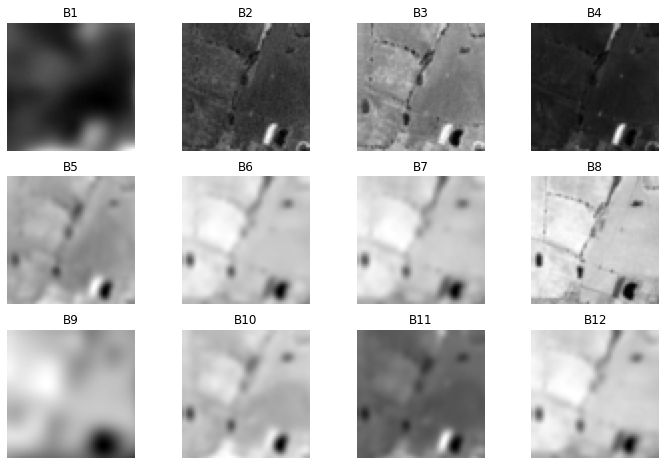

In [12]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0, 1))
    upper_perc = np.percentile(band_data, 98, axis=(0, 1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

def visualize_bands(sample) -> None:
    """
    Visualize all bands of an image
    :param sample: image of shape (12xWxH)
    :return: None; show plot
    """
    img = reshape_as_image(sample)
    normalized_img = normalize_for_display(img)
    fig, axs = plt.subplots(3, 4, figsize=(12, 8))
    b = 0
    for i in range(3):
        for j in range(4):
            idx = (i, j)
            axs[idx].imshow(normalized_img[:, :, b], cmap="gray")
            axs[idx].set_title(f"B{b+1}")
            axs[idx].axis(False)
            b += 1
    plt.show()

# Visualize bands of a training sample
visualize_bands(train_dataset[212][0].numpy())

## Define Model ##

In this section we define the model.

In [13]:
class Net(nn.Module):
    """
    Model used for ML-Challenge
    """
    def __init__(self):
        """
        Model definition
        """
        super().__init__()
        self.conv1 = nn.Conv2d(12, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 72, 5)

        self.fc1 = nn.Linear(72 * 13 * 13, 512)
        self.fc2 = nn.Linear(512, 124)
        self.fc3 = nn.Linear(124, 10)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

We also check how many parameters are to be trained.

In [14]:
num_params = 0
for param in net.parameters():
    num_params += param.numel()

print("Number of to be trained model parameters: {}.".format(num_params))

Number of to be trained model parameters: 6345886.


We then move the created model to the GPU device if cuda is available.

In [15]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [16]:
net = net.to(device)
!nvidia-smi

Sun May 22 11:21:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W /  70W |   1274MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Train Model ##

In this section we train our model with a cross-entropy loss utilizing stochasting gradient descent.

In [17]:
# Define optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

criterion = criterion.to(device)

In [18]:
train_epoch_losses = []
validation_epoch_losses = []
validation_epoch_accuracy = [] 

epochs = 51
for epoch in range(epochs):  # loop over the dataset multiple times

    # init collection of mini-batch losses
    train_mini_batch_losses = []
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
            
    # Per epoch store the training... 
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)
    # ...and validation loss, ...
    with torch.no_grad():
        validation_mini_batch_losses = []
        total = 0
        correct = 0
        for (images, labels) in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            validation_epoch_loss = criterion(outputs, labels)
            # collect mini-batch reconstruction loss
            validation_mini_batch_losses.append(loss.data.item())

            # add values to compute accuracy afterwards
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_epoch_loss = np.mean(validation_mini_batch_losses)
        validation_epoch_losses.append(validation_epoch_loss)
        accuracy = correct / total
        validation_epoch_accuracy.append(accuracy)
    # ...print statistics, ...
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss} validation-loss: {validation_epoch_loss} validation-accuracy: {(100*accuracy):.2f}%")
    # ...and save the model every 10 epochs
    if (epoch) % 10 == 0 and epoch != 0:
        if not os.path.exists(MODELS_PATH):
            os.mkdir(MODELS_PATH)
        print("Saving model")
        torch.save(
            net.state_dict(), os.path.join(MODELS_PATH, f"new_model_{epoch}.pth")
        )
print("Finished Training")

[LOG 20220522-11:21:51] epoch: 1 train-loss: 1.4137008357199894 validation-loss: 0.9406296014785767 validation-accuracy: 65.07%
[LOG 20220522-11:21:56] epoch: 2 train-loss: 0.822584118053412 validation-loss: 0.9601325988769531 validation-accuracy: 75.30%
[LOG 20220522-11:22:02] epoch: 3 train-loss: 0.6426796252560464 validation-loss: 0.7526640295982361 validation-accuracy: 80.57%
[LOG 20220522-11:22:07] epoch: 4 train-loss: 0.5128566043771756 validation-loss: 0.385940283536911 validation-accuracy: 84.09%
[LOG 20220522-11:22:12] epoch: 5 train-loss: 0.42327546029333857 validation-loss: 0.34845858812332153 validation-accuracy: 84.71%
[LOG 20220522-11:22:18] epoch: 6 train-loss: 0.37292555544027095 validation-loss: 0.7371949553489685 validation-accuracy: 87.21%
[LOG 20220522-11:22:23] epoch: 7 train-loss: 0.33047821662228577 validation-loss: 0.34172725677490234 validation-accuracy: 86.97%
[LOG 20220522-11:22:29] epoch: 8 train-loss: 0.29820141424039365 validation-loss: 0.4646140933036804 

### Evaluate model ###

We evaluate our model in three stages:
1. We plot the validation and training loss 
2. We calculate important classification metrics such as accuracy, precision and recall.
3. By plotting a confusion matrix we are able to look at the performance per class

Thereby we check for over- and underfitting, overall performance and performance per class.

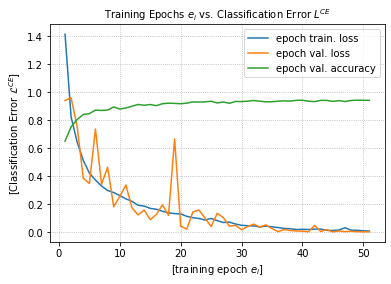

In [19]:
def visualize_losses_during_training(train_epoch_losses: List[float], validation_epoch_losses: List[float], validation_epoch_accuracy: List[float]) -> None:
    """
    Visualizes losses gathered during training.
    :param train_epoch_losses: List containing training loss per epoch
    :param validation_epoch_losses: List containing validation loss per epoch
    :param validation_epoch_accuracy: List containing validation accuracy per epoch

    :return: None
    """
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # add grid
    ax.grid(linestyle="dotted")

    # plot the training epochs vs. the epochs' classification error
    ax.plot(np.array(range(1, len(train_epoch_losses) + 1)), train_epoch_losses, label='epoch train. loss')
    ax.plot(np.array(range(1, len(validation_epoch_losses) + 1)), validation_epoch_losses,
            label='epoch val. loss')
    ax.plot(np.array(range(1, len(validation_epoch_accuracy) + 1)), validation_epoch_accuracy, label='epoch val. accuracy')

    # add axis legends
    ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
    ax.set_ylabel("[Classification Error $\\mathcal{L}^{CE}$]", fontsize=10)

    # set plot legend
    plt.legend(loc="upper right", numpoints=1, fancybox=True)

    # add plot title
    plt.title("Training Epochs $e_i$ vs. Classification Error $L^{CE}$", fontsize=10);

visualize_losses_during_training(train_epoch_losses, validation_epoch_losses, validation_epoch_accuracy)

In [20]:
y_pred = []
y_true = []
# iterate over test data
with torch.no_grad():
    for (images, labels) in tqdm(test_dataloader, desc="Predict labels"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)  # Feed Network
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())  # Save Prediction
        y_true.extend(labels.cpu().numpy())  # Save Truth

Predict labels: 100%|██████████| 55/55 [00:00<00:00, 69.12it/s]


In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       746
           1       0.98      0.99      0.99       796
           2       0.97      0.91      0.94       802
           3       0.85      0.85      0.85       647
           4       0.95      0.93      0.94       654
           5       0.92      0.94      0.93       494
           6       0.91      0.90      0.91       646
           7       0.96      0.96      0.96       776
           8       0.93      0.97      0.95       669
           9       1.00      0.99      1.00       770

    accuracy                           0.94      7000
   macro avg       0.94      0.94      0.94      7000
weighted avg       0.94      0.94      0.94      7000



Additionally, we visualize some of the images, to get a better understanding of our classifier.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


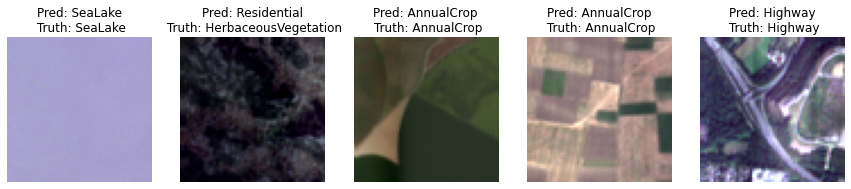

In [22]:
sample_truth = []
sample_pred = []

batch_images, batch_labels = next(iter(test_dataloader))

with torch.no_grad():
  sample_truth = [classes_to_label[int(batch_labels[j])] for j in range(5)]
  batch_images = batch_images.to(device)
  outputs = net(batch_images)
  _, predicted = torch.max(outputs, 1)
  sample_pred = [classes_to_label[int(predicted[j])] for j in range(5)]
  
fig, axes = plt.subplots(1,5, figsize=(15,15))
for index, ax in enumerate(axes):
  normalized_img = normalize_for_display(batch_images[index].cpu().numpy())
  rgb_img = reshape_as_image(normalized_img[[3,2,1], :, :])
  ax.imshow(rgb_img)
  ax.set_title(f"Pred: {sample_pred[index]}\n Truth: {sample_truth[index]}")
  ax.axis(False)
plt.show()


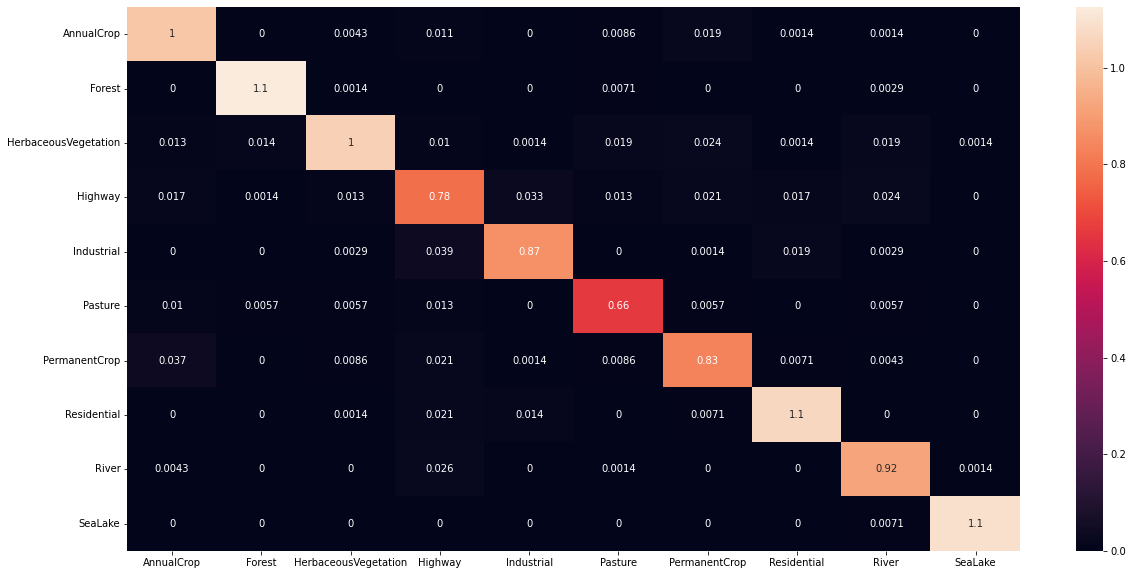

In [24]:
def plot_confusion_matrix(y_true: List[int], y_pred: List[int]) -> None:
    """
    Plot confusion matrix for predictions
    :param y_true: List containing true labels
    :param y_pred: List containing predicted labels
    :return: None; show plot
    """
    classes_in_order = [v for k, v in sorted(classes_to_label.items())]
    cm = confusion_matrix(y_true, y_pred)

    df_confusion_matrix = pd.DataFrame(
        cm / np.sum(cm) * 10,
        index=classes_in_order,
        columns=classes_in_order
    )
    plt.figure(figsize=(20, 10))
    sns.heatmap(df_confusion_matrix, annot=True)

plot_confusion_matrix(y_true, y_pred)

## Create submission ##

#### Load Model

In [25]:
!ls models

new_model_10.pth  new_model_30.pth  new_model_50.pth
new_model_20.pth  new_model_40.pth


In [26]:
selected_model_path = "new_model_20.pth"
net = Net()
net.load_state_dict(torch.load(os.path.join(MODELS_PATH, selected_model_path)))

<All keys matched successfully>

#### Load submission data

We first download the data from a Github repository and then define a custom dataset where the bands are brought in order. We normalize the data with precomputed means and standard deviations over all submission data samples of all bands, since this dataset is slightly different than the training dataset.

In [27]:
!git clone https://github.com/rbngz/submission_dataset

Cloning into 'submission_dataset'...
remote: Enumerating objects: 4235, done.
remote: Total 4235 (delta 0), reused 0 (delta 0), pack-reused 4235
Receiving objects: 100% (4235/4235), 301.48 MiB | 13.83 MiB/s, done.
Checking out files: 100% (4232/4232), done.


In [28]:
submission_means_tuple = (380.17328711583616, 400.1497676971955, 628.8646132355601, 578.870857455104, 943.4272711885449, 1826.2433534560898, 2116.6662455740857, 2205.972884006897, 2281.1860589241937, 2266.934157142567, 1487.6910683644517, 959.236167229867)
submission_stds_tuple = (115.17434877174112, 209.14842754591166, 241.20653977105658, 301.1056228200069, 269.5139533673432, 420.2497496130561, 503.8183661547185, 598.040304209199, 529.4133153492427, 403.93781724898935, 398.143166872752, 342.44079144555366)
submission_normalizer = torchvision.transforms.Normalize(submission_means_tuple, submission_stds_tuple)

In [29]:
class SubmissionDataset(torch.utils.data.Dataset):
    def __init__(self, submission_samples, normalizer=submission_normalizer):
        self.x = []
        for _, submission_sample in tqdm(
            sorted(
                {
                    # Sort files by index
                    int(re.findall("\d+", submission_sample)[0]): submission_sample
                    for submission_sample in submission_samples
                }.items()
            ),
            desc="Loading submission samples"
        ):
            # Extract bands
            img = np.load(submission_sample)

            # SWAP BANDS
            tmp = img[:, :, 8].copy()
            img = np.delete(img, 8, axis=2)
            img = np.insert(img, 11, tmp, axis=2)

            tens = torch.from_numpy(img.astype(int))
            tens = tens.permute(2, 1, 0)

            # Normalize
            tens = normalizer(tens.float())
            self.x.append(tens)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

In [30]:
submission_testset_samples = glob.glob(os.path.join(SUBMISSION_DATA_PATH, "*.npy"))
submission_dataset = SubmissionDataset(submission_testset_samples)

submission_dataloader = torch.utils.data.DataLoader(
    submission_dataset,
    batch_size=1,
    shuffle=False,
)

Loading submission samples: 100%|██████████| 4232/4232 [00:03<00:00, 1174.02it/s]


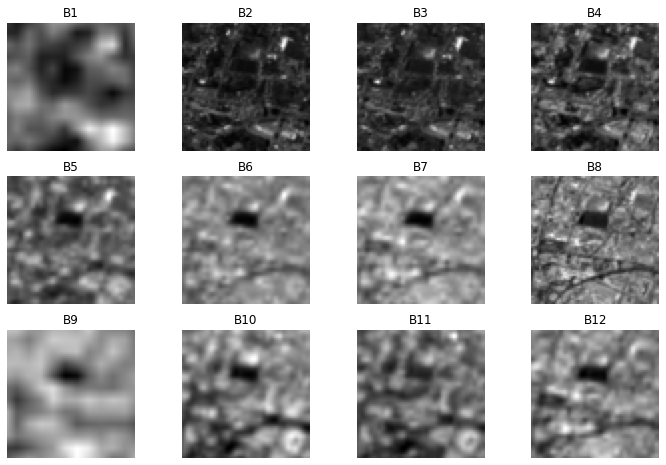

In [31]:
visualize_bands(submission_dataset[212].numpy())

#### Create submission ####

Finally, we create a csv file that we are able to upload to kaggle. :)

In [32]:
def create_submission(net, submission_dataloader, filename: str = "submission.csv"):
    """
    Helper method which creates a Kaggle submission from a given model and
    :param net:
    :param submission_dataloader:
    :param filename:
    :return:
    """
    submission_results = []

    index = 0
    with torch.no_grad():
        for images in iter(submission_dataloader):
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            label = classes_to_label[int(predicted[0])]
            # Print predicted sample every once in a while
            if index % 1000 == 0:
                print(f"Predicted: {label}")
            submission_results.append([index, label])
            index += 1

    # field names
    fields = ["test_id", "label"]

    # writing to csv file
    with open(filename, "w") as csvfile:
        # creating a csv writer object
        csv_writer = csv.writer(csvfile)

        # writing the fields
        csv_writer.writerow(fields)

        # writing the data rows
        csv_writer.writerows(submission_results)
    print(f"Submission was written to ./{filename}")

create_submission(net, submission_dataloader)

Predicted: Forest
Predicted: Highway
Predicted: River
Predicted: Pasture
Predicted: SeaLake
Submission was written to ./submission.csv


To double check that the submission seems reasonable, we quickly look at the counts of the predictions per class.

In [33]:
import pandas as pd
df = pd.read_csv("submission.csv")
df["label"].value_counts()

SeaLake          1026
AnnualCrop        949
Forest            748
Pasture           645
River             348
Highway           326
Industrial        139
PermanentCrop      51
Name: label, dtype: int64

Additionally, we can also randomly sample a few images and visualize them to make sure that our model predicts somewhat reasonably. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


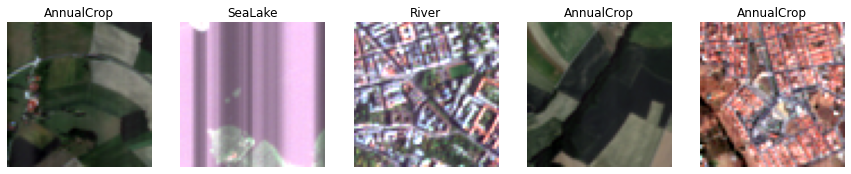

In [34]:
import random

fig, axes = plt.subplots(1,5, figsize=(15,15))
for ax in axes:
  index = random.randint(0, len(df)-1)
  normalized_img = normalize_for_display(submission_dataset[index].numpy())

  rgb_img = reshape_as_image(normalized_img[[3,2,1], :, :])

  ax.imshow(rgb_img)
  ax.set_title(f"{df.iloc[index]['label']}")
  ax.axis(False)

plt.show()